**CS166 Assignment 3 Network simulation**

Reusing the code from the 7.2 in-class notebook.

In [1]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import random

In [2]:
from scipy import stats

In [190]:
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4, individual=True, multi_op=True):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.
              
            individual (Boolean) The truth value of whether the simulation will be
              run with individual alpha, beta, and gamma parameters or unified 
              parameters for all.
              
            multi_op (Boolean) The truth value of whether the simulation will be
              run with multiple opinions (vector) or a single opinion.

            alpha (float) If non-individualized, the rate at which nodes adjust
              their opinions to match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) If non-individualized, the rate at which edge weights are
              changed in response to differing opinions. Default: 0.3.

            gamma (float) If non-individualized, the pickiness of nodes. Nodes
              with opinions differing by more than 1/gamma will result
              in an edge weight decreasing.
              Default: 4.
        '''
        self.network_size = network_size
        self.individual = individual
        self.multi_op = multi_op
        
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.watts_strogatz_graph(50, 5, 0.5)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
            
        if self.multi_op == False:
            for node in self.graph.nodes:
                self.graph.nodes[node]['opinion'] = random.randint(0, 1)
        else:
            '''
            Opinion generator
            '''
            # Generate individual opinion weights once. 
            for node in self.graph.nodes:
                weight1 = random.uniform(0,0.5)
                weight2 = random.uniform(0,0.5)
                weight3 = 1-weight1-weight2
                self.graph.nodes[node]['op_weights'] = [weight1,weight2,weight3]

            # Generate individual opinions.
            # In the first ireration, each person will only have
            # 0s and 1s, weighted at their respective importance,
            # for each node, in forming their final opinion.

            for node in self.graph.nodes:
                self.graph.nodes[node]['opinion'] = [random.choice([0,1]) for i in range(3)]

            # Weigh each opinion accordingly
            # and create a final_opinion property.
            for node in self.graph.nodes:
                opinions = self.graph.nodes[node]['opinion']
                op_weights = self.graph.nodes[node]['op_weights']
                self.graph.nodes[node]['final_opinion'] = opinions[0]*op_weights[0]+opinions[1]*op_weights[1]+opinions[2]*op_weights[2]

        if self.individual==True:
            '''
            Initiating individual parameters.
            '''
            for node in self.graph.nodes:
                self.graph.nodes[node]['alpha'] = abs(stats.norm(0.5,0.1).rvs())

            for node in self.graph.nodes:
                self.graph.nodes[node]['beta'] = abs(stats.norm(0.3,0.1).rvs())
                
            for node in self.graph.nodes:
                betas = [self.graph.nodes[node]['beta'] for node in self.graph.nodes]
                
                # Define the lower and the upper bounds
                # as well as the mean and SD for the Gaussian
                # from which individual gammas will be sampled. 
                lower, upper = 1, 1+1/(min(betas))
                mu, sigma = 1+1/(np.mean(betas)), 0.25
                x = stats.truncnorm(
                    (lower-mu)/sigma, (upper-mu)/sigma, loc=mu, scale=sigma)
                self.graph.nodes[node]['gamma'] = x.rvs()
                
            for node in self.graph.nodes:
                self.graph.nodes[node]['persuasion'] = abs(stats.norm(self.graph.nodes[node]['alpha'],0.25).rvs())

        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        
        if self.multi_op==False:
            node_color = [self.graph.nodes[i]['opinion'] for i in self.graph.nodes]
        else:
            node_color = [self.graph.nodes[i]['final_opinion'] for i in self.graph.nodes]
            
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=node_color,
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        plt.title('Step: ' + str(self.step))

    def update(self):
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            # If multi_op==True, it is now a list of 2 lists. 
            
            if self.individual==True:
                # Create lists of individualized parameters for all nodes.
                alphas = [self.graph.nodes[n]['alpha'] for n in edge]
                betas = [self.graph.nodes[n]['beta'] for n in edge]
                gammas = [self.graph.nodes[n]['gamma'] for n in edge]
                persuasion = [self.graph.nodes[n]['persuasion'] for n in edge]
            
            if self.multi_op==False:
            
                # Opinion update
                for i in [0, 1]:
                    if self.individual==True:
                        self.graph.nodes[edge[i]]['opinion'] = (
                            opinions[i] + alphas[i] * weight * (opinions[1-i] - opinions[i])*(persuasion[1-i]/(persuasion[1-i]+persuasion[i])))
                    else:
                        self.graph.nodes[edge[i]]['opinion'] = (
                            opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))
            else:
                # the topic that the current two nodes will converse about
                current_topic = random.randint(0,2) 
            
                # Opinion update (single, on the current topic)
                for i in [0, 1]:
                    if self.individual==True:
                        self.graph.nodes[edge[i]]['opinion'][current_topic] = (
                            opinions[i][current_topic] + alphas[i] * weight * (opinions[1-i][current_topic] -
                                                                               opinions[i][current_topic])*(persuasion[1-i]/(persuasion[1-i]+persuasion[i])))
                    else:
                        self.graph.nodes[edge[i]]['opinion'][current_topic] = (
                            opinions[i][current_topic] + self.alpha * weight * (opinions[1-i][current_topic] - opinions[i][current_topic]))
            
                # Final opinion update
                all_opinions = [self.graph.nodes[n]['opinion'] for n in edge]
                # 2 lists of lists of 3, where the opinion on the topic they just discussed is now updated
                op_weights = [self.graph.nodes[n]['op_weights'] for n in edge]
                
                for i in [0, 1]:
                    self.graph.nodes[edge[i]]['final_opinion'] = all_opinions[i][0]*op_weights[i][0]+all_opinions[i][1]*op_weights[i][1]+all_opinions[i][2]*op_weights[i][2]
            
            # Weights update
            if self.multi_op==False:
                opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            else:
                opinions = [self.graph.nodes[n]['final_opinion'] for n in edge]
            if self.individual==True:
                beta = 0.5*betas[0]+0.5*betas[1]
                gamma = 0.5*gammas[0]+0.5*gammas[1]
            else:
                gamma = self.gamma
                beta = self.beta

            self.graph.edges[edge]['weight'] = (
                weight +
                beta * weight * (1-weight) *
                (1 - gamma * abs(opinions[0] - opinions[1])))
            
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

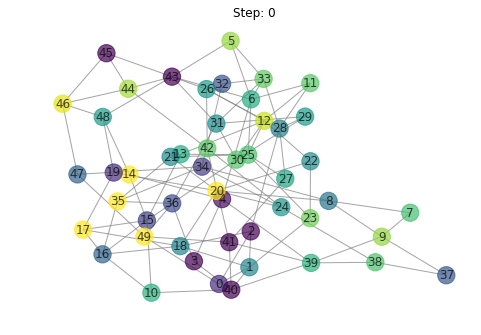

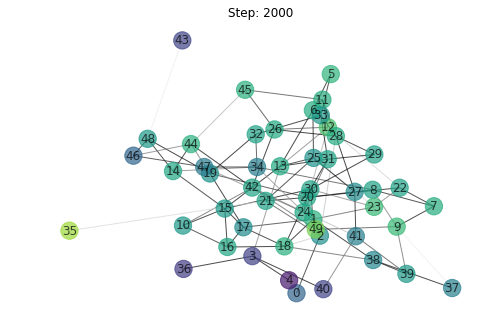

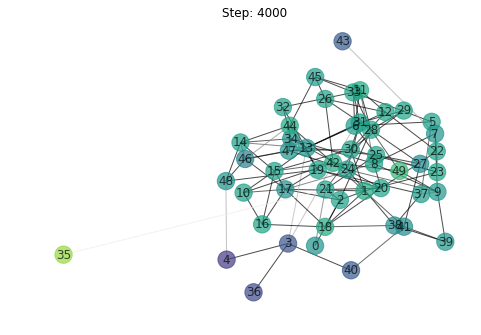

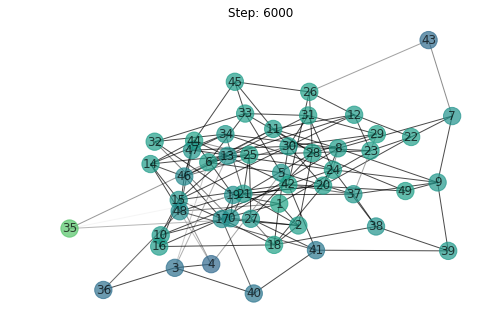

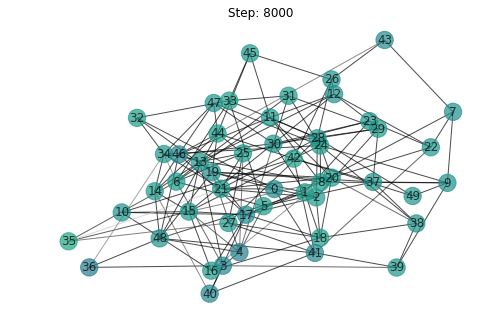

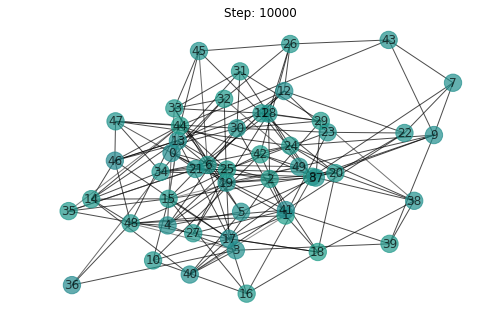

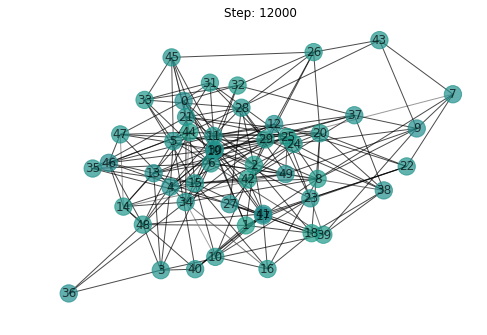

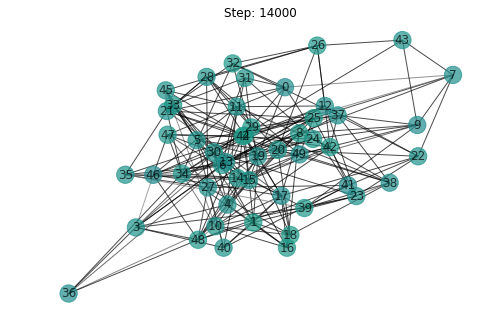

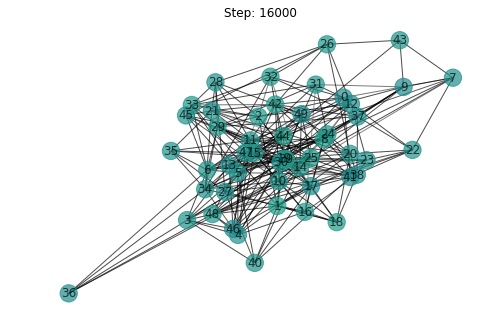

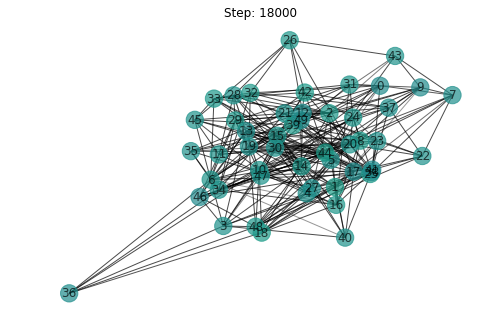

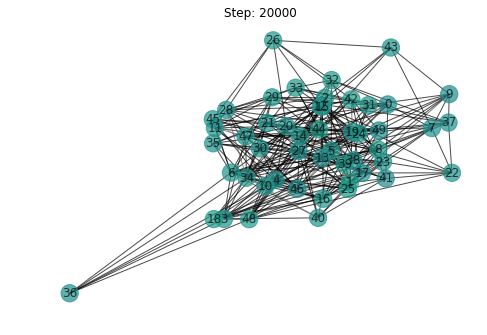

In [191]:
sim = SocialDynamicsSimulation()
sim.initialize()
plt.figure()
sim.observe()
for i in range(10):
    for i in range(2000):
        sim.update()
    plt.figure()
    sim.observe()

***Vector plot: Opinion difference vs weights***

Re-using solutions notebook from Session 7.2.

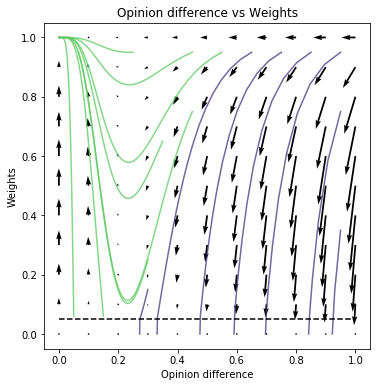

In [189]:
from matplotlib import pyplot
import itertools
import scipy

alpha1 = 0.6
alpha2 = 0.4
beta = 0.3
gamma = 1+1/beta

pyplot.figure(figsize=(16,6))
cmap = pyplot.cm.viridis

# Plot traces of how opinion and weight change over time
for opinion, weight in [
    [0.25, 0.95], [0.45, 0.95], [0.55, 0.95], [0.65, 0.95], [0.75, 0.95],
    [0.85, 0.95], [0.95, 0.95], [0.35, 0.65], [0.45, 0.75], [0.95, 0.75],
    [0.95, 0.35], [0.3, 0.25], [0.3, 0.15], [0.15, 0.06], [0.05, 0.06]
]:
    ow = [[opinion, 0.0, weight]]
    for i in range(100):
        delta_o1 = alpha * ow[-1][2] * (ow[-1][1] - ow[-1][0])
        delta_o2 = alpha * ow[-1][2] * (ow[-1][0] - ow[-1][1])
        
        new_o1 = ow[-1][0] + delta_o1
        new_o2 = ow[-1][1] + delta_o2
        
        delta_w = (
            beta * ow[-1][2] * (1-ow[-1][2]) *
            (1-gamma*abs(new_o2 - new_o1)))

        new_weight = ow[-1][2] + delta_w
        if new_weight < 0.05:
            new_weight = 0
        ow.append([new_o1, new_o2, new_weight])
    pyplot.plot(
        [row[0] - row[1] for row in ow],
        [row[2] for row in ow],
        color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)),
        alpha=0.75)

opinion = scipy.linspace(0, 1, 11)  # the difference in opinion, |o_i - o_j|
weight = scipy.linspace(0, 1, 11)   # the edge weight, w_ij
ow_grid = scipy.meshgrid(opinion, weight)
delta_o_grid = -2*alpha * ow_grid[1] * ow_grid[0]
delta_w_grid = beta * ow_grid[1] * (1-ow_grid[1]) * (1 - gamma * ow_grid[0])
pyplot.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid)

pyplot.xlabel('Opinion difference')
pyplot.ylabel('Weights')
pyplot.title('Opinion difference vs Weights')
pyplot.plot([0, 1], [0.05, 0.05], 'k--')
pyplot.axis('square')
pyplot.show()